# **0. Import Libraries & Setup**

In [57]:
# Standard Libraries
import os
import warnings
from collections import Counter

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Imputation
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model Selection & Feature Selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFECV, SelectKBest, chi2, f_classif, mutual_info_classif, SelectFromModel

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics & Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance

# Statistical Analysis & Utilities
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE

# Warnings
warnings.filterwarnings('ignore')

In [58]:
# Display setup
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)

# **1. Load Dataset**

In [59]:
train_df = pd.read_csv(r'merged_credit_data_train.csv')
test_df = pd.read_csv(r'merged_credit_data_test.csv')
print(f"Main train application data: {train_df.shape}")
print(f"Main test application data: {test_df.shape}")

Main train application data: (307511, 134)
Main test application data: (48744, 133)


# **2. Split Dataset**

In [60]:
X = train_df.drop(columns='TARGET')
y = train_df['TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test = test_df

# **3. Handling Duplicates**

In [61]:
print(X_train.duplicated(subset='SK_ID_CURR').sum().sum())
print(X_test.duplicated(subset='SK_ID_CURR').sum().sum())
print(X_val.duplicated(subset='SK_ID_CURR').sum().sum())

0
0
0


# **4. Handling Missing Values**

In [62]:
missing_train = X_train.isna().sum()
missing_train = missing_train[missing_train > 0].reset_index()
missing_train.columns = ["column", "missing_count"]
missing_train["missing_pct"] = (missing_train["missing_count"] / len(X_train)) * 100
missing_train = missing_train.sort_values(by="missing_pct", ascending=False)
print("Missing values in train dataset:")
print(missing_train)

missing_test = X_test.isna().sum()
missing_test = missing_test[missing_test > 0].reset_index()
missing_test.columns = ["column", "missing_count"]
missing_test["missing_pct"] = (missing_test["missing_count"] / len(X_test)) * 100
missing_test = missing_test.sort_values(by="missing_pct", ascending=False)
print("\nMissing values in test dataset:")
print(missing_test)

missing_test = X_val.isna().sum()
missing_test = missing_test[missing_test > 0].reset_index()
missing_test.columns = ["column", "missing_count"]
missing_test["missing_pct"] = (missing_test["missing_count"] / len(X_val)) * 100
missing_test = missing_test.sort_values(by="missing_pct", ascending=False)
print("\nMissing values in test dataset:")
print(missing_test)

Missing values in train dataset:
                          column  missing_count  missing_pct
13                COMMONAREA_AVG         171811        69.84
27               COMMONAREA_MODE         171811        69.84
41               COMMONAREA_MEDI         171811        69.84
35      NONLIVINGAPARTMENTS_MODE         170729        69.40
21       NONLIVINGAPARTMENTS_AVG         170729        69.40
49      NONLIVINGAPARTMENTS_MEDI         170729        69.40
51            FONDKAPREMONT_MODE         168215        68.38
47         LIVINGAPARTMENTS_MEDI         168119        68.34
33         LIVINGAPARTMENTS_MODE         168119        68.34
19          LIVINGAPARTMENTS_AVG         168119        68.34
45                FLOORSMIN_MEDI         166921        67.85
31                FLOORSMIN_MODE         166921        67.85
17                 FLOORSMIN_AVG         166921        67.85
26              YEARS_BUILD_MODE         163543        66.48
12               YEARS_BUILD_AVG         163543     

Rows without missing values: 8,602 (2.8%)
Rows with missing values: 298,909 (97.2%)

Missing values distribution per row:
49    50116
48    46616
50    29609
2     27478
1     25737
3     16949
47    16187
0      8602
18     6839
17     6491
Name: count, dtype: int64

Statistics of missing values per row:
Min missing per row: 0
Max missing per row: 55
Mean missing per row: 28.95
Median missing per row: 35.00


Text(0, 0.5, 'Frequency')

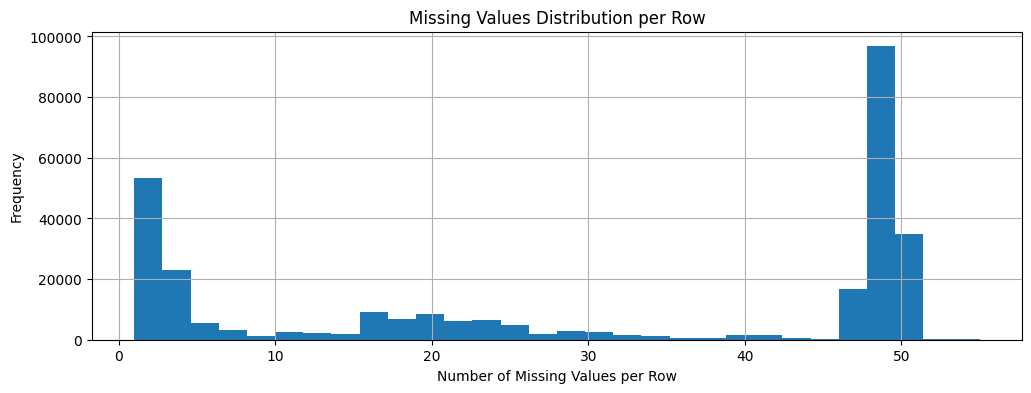

In [63]:
# How many rows have missing values
missing_per_row = train_df.isnull().sum(axis=1)
print(f"Rows without missing values: {(missing_per_row == 0).sum():,} ({(missing_per_row == 0).mean()*100:.1f}%)")
print(f"Rows with missing values: {(missing_per_row > 0).sum():,} ({(missing_per_row > 0).mean()*100:.1f}%)")

# Distribution of number of missing values per row
print(f"\nMissing values distribution per row:")
print(missing_per_row.value_counts().head(10))

print(f"\nStatistics of missing values per row:")
print(f"Min missing per row: {missing_per_row.min()}")
print(f"Max missing per row: {missing_per_row.max()}")
print(f"Mean missing per row: {missing_per_row.mean():.2f}")
print(f"Median missing per row: {missing_per_row.median():.2f}")

# Plot distribution of missing values per row
plt.figure(figsize=(12, 4))
missing_per_row[missing_per_row > 0].hist(bins=30)
plt.title('Missing Values Distribution per Row')
plt.xlabel('Number of Missing Values per Row')
plt.ylabel('Frequency')

In [64]:
# Correlation among missing values
missing_df = X_train.isnull().astype(int)
missing_corr = missing_df.corr()

# Find highly correlated (> 0.8) missing value pairs
high_corr_pairs = []
for i in range(len(missing_corr.columns)):
    for j in range(i + 1, len(missing_corr.columns)):
        corr_val = missing_corr.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((missing_corr.columns[i], missing_corr.columns[j], corr_val))

# Check important columns
important_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
available_cols = [col for col in important_cols if col in X_train.columns]

# Identify groups of columns with identical missing patterns
perfect_corr_groups = {}
processed_cols = set()
for col in missing_corr.columns:
    if col in processed_cols:
        continue
    perfect_matches = missing_corr[col][missing_corr[col] == 1.0].index.tolist()
    perfect_matches = [c for c in perfect_matches if c != col]
    if perfect_matches:
        group_name = f"Group_{len(perfect_corr_groups) + 1}"
        perfect_corr_groups[group_name] = [col] + perfect_matches
        processed_cols.update([col] + perfect_matches)

# Display results in console
print("=== Column Pairs with Very High Missing Correlation (>0.8) ===")
print(f"Total pairs: {len(high_corr_pairs)}")
for col1, col2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
    print(f"{col1} <-> {col2}: {corr:.3f}")

print("\n=== Missing Correlation - Important Columns ===")
if len(available_cols) > 1:
    print("Missing correlation among EXT_SOURCE columns:")
    for i, col1 in enumerate(available_cols):
        for col2 in available_cols[i + 1:]:
            corr_val = missing_corr.loc[col1, col2]
            print(f"{col1} <-> {col2}: {corr_val:.3f}")
else:
    print("Important EXT_SOURCE columns are incomplete.")

print("\n=== Groups of Columns with Identical Missing Patterns ===")
print(f"Found {len(perfect_corr_groups)} column groups")
for group_name, cols in perfect_corr_groups.items():
    print(f"{group_name}: {len(cols)} columns")
    print(f"  Sample: {cols[:3]}{'...' if len(cols) > 3 else ''}")

=== Column Pairs with Very High Missing Correlation (>0.8) ===
Total pairs: 582
APARTMENTS_AVG <-> APARTMENTS_MODE: 1.000
APARTMENTS_AVG <-> APARTMENTS_MEDI: 1.000
BASEMENTAREA_AVG <-> BASEMENTAREA_MODE: 1.000
BASEMENTAREA_AVG <-> BASEMENTAREA_MEDI: 1.000
YEARS_BEGINEXPLUATATION_AVG <-> YEARS_BEGINEXPLUATATION_MODE: 1.000
YEARS_BEGINEXPLUATATION_AVG <-> YEARS_BEGINEXPLUATATION_MEDI: 1.000
YEARS_BUILD_AVG <-> YEARS_BUILD_MODE: 1.000
YEARS_BUILD_AVG <-> YEARS_BUILD_MEDI: 1.000
COMMONAREA_AVG <-> COMMONAREA_MODE: 1.000
COMMONAREA_AVG <-> COMMONAREA_MEDI: 1.000
ELEVATORS_AVG <-> ELEVATORS_MODE: 1.000
ELEVATORS_AVG <-> ELEVATORS_MEDI: 1.000
ENTRANCES_AVG <-> ENTRANCES_MODE: 1.000
ENTRANCES_AVG <-> ENTRANCES_MEDI: 1.000
FLOORSMAX_AVG <-> FLOORSMAX_MODE: 1.000
FLOORSMAX_AVG <-> FLOORSMAX_MEDI: 1.000
FLOORSMIN_AVG <-> FLOORSMIN_MODE: 1.000
FLOORSMIN_AVG <-> FLOORSMIN_MEDI: 1.000
LANDAREA_AVG <-> LANDAREA_MODE: 1.000
LANDAREA_AVG <-> LANDAREA_MEDI: 1.000
LIVINGAPARTMENTS_AVG <-> LIVINGAPARTMENT

In [65]:
X_train_clean = X_train.copy()
X_val_clean = X_val.copy()
X_test_clean = X_test.copy()

print("=== MISSING VALUES HANDLING: TRAIN-VAL-TEST ===")
print(f"Train shape: {X_train_clean.shape}, Val shape: {X_val_clean.shape}, Test shape: {X_test_clean.shape}")

# DROP REDUNDANT COLUMNS
print("\n1. DROP REDUNDANT COLUMNS")

# Building features redundant
building_features = ['APARTMENTS', 'BASEMENTAREA', 'YEARS_BEGINEXPLUATATION', 'YEARS_BUILD', 'COMMONAREA', 'ELEVATORS', 'ENTRANCES', 'FLOORSMAX', 'FLOORSMIN', 'LANDAREA', 'LIVINGAPARTMENTS', 'LIVINGAREA', 'NONLIVINGAPARTMENTS', 'NONLIVINGAREA']

cols_to_drop = []
for feature in building_features:
    for suffix in ['_MODE', '_MEDI']:
        col_name = f"{feature}{suffix}"
        if col_name in X_train_clean.columns:
            cols_to_drop.append(col_name)

# Social circle redundant
social_redundant = ['DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']
for col in social_redundant:
    if col in X_train_clean.columns:
        cols_to_drop.append(col)

# Drop from all three datasets
for df in [X_train_clean, X_val_clean, X_test_clean]:
    df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

print(f"Dropped {len(cols_to_drop)} redundant columns")

# FEATURE ENGINEERING - BUILDING INFO
print("\n2. FEATURE ENGINEERING - BUILDING INFO")

building_proxy = 'APARTMENTS_AVG'
if building_proxy in X_train_clean.columns:
    for df in [X_train_clean, X_val_clean, X_test_clean]:
        df['HAS_BUILDING_INFO'] = (~df[building_proxy].isnull()).astype(int)

# Drop all building-related features
building_keywords = ['APARTMENTS', 'BASEMENT', 'FLOORS', 'ELEVATOR', 'ENTRANCE',
                     'LIVING', 'NONLIVING', 'COMMON', 'LAND', 'TOTAL', 'WALL', 'HOUSE',
                     'EMERGENCY', 'YEARS_BEGIN', 'YEARS_BUILD', 'FONDKA']

for df in [X_train_clean, X_val_clean, X_test_clean]:
    cols_to_drop_building = [col for col in df.columns if any(k in col for k in building_keywords)]
    df.drop(columns=cols_to_drop_building, errors='ignore', inplace=True)

print(f"Dropped building features from all datasets")

# HANDLE EXT_SOURCE
print("\n3. HANDLE EXT_SOURCE FEATURES")

ext_sources = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
available_ext = [col for col in ext_sources if col in X_train_clean.columns]

if available_ext:
    for col in available_ext:
        for df in [X_train_clean, X_val_clean, X_test_clean]:
            df[f'{col}_IS_MISSING'] = df[col].isnull().astype(int)

    if len(available_ext) > 1:
        imputer = IterativeImputer(random_state=42, max_iter=10)
        imputer.fit(X_train_clean[available_ext])
        for df in [X_train_clean, X_val_clean, X_test_clean]:
            df[available_ext] = imputer.transform(df[available_ext])
    else:
        for col in available_ext:
            median_val = X_train_clean[col].median()
            for df in [X_train_clean, X_val_clean, X_test_clean]:
                df[col].fillna(median_val, inplace=True)

print("EXT_SOURCE imputation completed")

# HANDLE REMAINING MISSING VALUES
print("\n4. HANDLE REMAINING MISSING VALUES")

# Drop columns with >50% missing in train
remaining_missing_train = X_train_clean.isnull().sum()
remaining_missing_train = remaining_missing_train[remaining_missing_train > 0]
cols_to_drop_high_missing = [col for col in remaining_missing_train.index if remaining_missing_train[col] / len(X_train_clean) > 0.5]

for df in [X_train_clean, X_val_clean, X_test_clean]:
    df.drop(columns=cols_to_drop_high_missing, errors='ignore', inplace=True)

# Impute remaining missing values
remaining_missing_train = X_train_clean.isnull().sum()
remaining_missing_train = remaining_missing_train[remaining_missing_train > 0]

for col in remaining_missing_train.index:
    col_dtype = X_train_clean[col].dtype
    if col_dtype in ['object', 'category']:
        fill_value = 'Unknown' if col == 'OCCUPATION_TYPE' else X_train_clean[col].mode()[0]
        for df in [X_train_clean, X_val_clean, X_test_clean]:
            df[col].fillna(fill_value, inplace=True)
    else:
        median_val = X_train_clean[col].median()
        for df in [X_train_clean, X_val_clean, X_test_clean]:
            df[col].fillna(median_val, inplace=True)

# FINAL CHECK
for name, df in zip(['Train', 'Val', 'Test'], [X_train_clean, X_val_clean, X_test_clean]):
    missing = df.isnull().sum().sum()
    print(f"{name} missing values after treatment: {missing:,}")
    print(f"{name} shape: {df.shape}")

# Check column consistency
train_cols = set(X_train_clean.columns) - {'TARGET'}
for dataset_name, df in zip(['Val', 'Test'], [X_val_clean, X_test_clean]):
    missing_cols = train_cols - set(df.columns)
    if missing_cols:
        print(f"Columns in train but not in {dataset_name}: {missing_cols}")

# Summary of new features
new_features = [col for col in X_train_clean.columns if 'IS_MISSING' in col or col == 'HAS_BUILDING_INFO']
print(f"New engineered features ({len(new_features)}): {new_features}")

=== MISSING VALUES HANDLING: TRAIN-VAL-TEST ===
Train shape: (246008, 133), Val shape: (61503, 133), Test shape: (48744, 133)

1. DROP REDUNDANT COLUMNS
Dropped 31 redundant columns

2. FEATURE ENGINEERING - BUILDING INFO
Dropped building features from all datasets

3. HANDLE EXT_SOURCE FEATURES
EXT_SOURCE imputation completed

4. HANDLE REMAINING MISSING VALUES
Train missing values after treatment: 0
Train shape: (246008, 85)
Val missing values after treatment: 0
Val shape: (61503, 85)
Test missing values after treatment: 0
Test shape: (48744, 85)
New engineered features (4): ['HAS_BUILDING_INFO', 'EXT_SOURCE_1_IS_MISSING', 'EXT_SOURCE_2_IS_MISSING', 'EXT_SOURCE_3_IS_MISSING']


# **5. Handling Outliers**

In [66]:
# List of categorical and numerical columns
cat_cols = ["NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE", "HAS_BUILDING_INFO", "EXT_SOURCE_1_IS_MISSING", "EXT_SOURCE_2_IS_MISSING", "EXT_SOURCE_3_IS_MISSING"]
num_cols = ["SK_ID_CURR", "CNT_CHILDREN", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "REGION_POPULATION_RELATIVE", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL", "CNT_FAM_MEMBERS", "REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY", "HOUR_APPR_PROCESS_START", "REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "OBS_30_CNT_SOCIAL_CIRCLE", "DAYS_LAST_PHONE_CHANGE", "FLAG_DOCUMENT_2", "FLAG_DOCUMENT_3", "FLAG_DOCUMENT_4", "FLAG_DOCUMENT_5", "FLAG_DOCUMENT_6", "FLAG_DOCUMENT_7", "FLAG_DOCUMENT_8", "FLAG_DOCUMENT_9", "FLAG_DOCUMENT_10", "FLAG_DOCUMENT_11", "FLAG_DOCUMENT_12", "FLAG_DOCUMENT_13", "FLAG_DOCUMENT_14", "FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16", "FLAG_DOCUMENT_17", "FLAG_DOCUMENT_18", "FLAG_DOCUMENT_19", "FLAG_DOCUMENT_20", "FLAG_DOCUMENT_21", "AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR", "CREDIT_ANNUITY_RATIO", "BUREAU_DAYS_CREDIT_MEAN", "BUREAU_CREDIT_SUM", "BUREAU_CREDIT_SUM_DEBT", "DEBT_CREDIT_RATIO", "PREV_AMT_APP_MEAN", "PREV_AMT_CREDIT_MEAN", "PREV_APPROVED_COUNT", "PREV_REFUSED_COUNT", "INST_PAYMENT_RATIO_MEAN", "POS_INSTAL_FUTURE_MEAN", "CC_BALANCE_MEAN"]

In [67]:
# Outlier detection, error handling, and missing value imputation
results = []

for col in num_cols:
    s = X_train_clean[col].dropna()
    if s.empty:
        continue

    issue = "clean"

    if any(prefix in col.upper() for prefix in ["AMT", "PAYMENT", "CREDIT", "LIMIT", "DEBT"]):
        if (s < 0).any():
            issue = "error (negatives found)"

    results.append([col, issue])

outlier_report = pd.DataFrame(results, columns=["Column", "Category"])
outlier_report = outlier_report[outlier_report["Category"] != "clean"]

# Error Handling
X_train_out = X_train_clean.copy()
X_test_out = X_test_clean.copy()
X_val_out = X_val_clean.copy()

days_cols = [col for col in X_train_out.columns if 'DAYS' in col.upper()]
error_cols = outlier_report[outlier_report["Category"].str.contains("error")]["Column"].tolist()

for col in error_cols:
    for df in [X_train_out, X_val_out, X_test_out]:
        df[col] = df[col].mask(df[col] < 0)

for col in days_cols:
    for df in [X_train_out, X_val_out, X_test_out]:
        df[col] = df[col].mask(df[col].abs() >= 365243)

for col in X_train_out.columns:
    if X_train_out[col].isnull().sum() > 0:
        if X_train_out[col].dtype in ['object', 'category']:
            fill_value = 'Unknown' if col == 'OCCUPATION_TYPE' else X_train_out[col].mode()[0]
            for df in [X_train_out, X_val_out, X_test_out]:
                df[col].fillna(fill_value, inplace=True)
        else:
            median_val = X_train_out[col].median()
            for df in [X_train_out, X_val_out, X_test_out]:
                df[col].fillna(median_val, inplace=True)

In [68]:
# Outlier and skewness summary for numerical columns
combined_summary = []

for col in num_cols:
    if X_train_out[col].std() == 0:
        continue

    Q1 = X_train_out[col].quantile(0.25)
    Q3 = X_train_out[col].quantile(0.75)
    IQR = Q3 - Q1

    if IQR == 0:
        lower_bound = X_train_out[col].min()
        upper_bound = X_train_out[col].max()
    else:
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

    outliers = X_train_out[(X_train_out[col] < lower_bound) | (X_train_out[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(X_train_out)) * 100

    skew_val = X_train_out[col].skew()

    combined_summary.append({
        'Column': col,
        'Outlier_Percent': round(outlier_percent, 2),
        'Skewness': round(skew_val, 2),
        'Min': round(X_train_out[col].min(), 2),
        'Max': round(X_train_out[col].max(), 2)
    })

combined_df = pd.DataFrame(combined_summary)
combined_df = combined_df.sort_values('Outlier_Percent', ascending=False)
display(combined_df[combined_df['Outlier_Percent'] > 0])

,Column,Outlier_Percent,Skewness,Min,Max
65,INST_PAYMENT_RATIO_MEAN,20.82,171.26,0.00,"8,482.45"
59,BUREAU_CREDIT_SUM_DEBT,10.80,46.93,0.00,"334,498,331.21"
64,PREV_REFUSED_COUNT,10.11,4.94,0.00,58.00
58,BUREAU_CREDIT_SUM,8.54,85.20,0.00,"1,017,957,917.38"
26,EXT_SOURCE_1,7.60,-0.12,0.01,0.95
7,DAYS_EMPLOYED,7.52,-2.29,"-17,912.00",0.00
61,PREV_AMT_APP_MEAN,7.06,3.53,0.00,"4,050,000.00"
29,OBS_30_CNT_SOCIAL_CIRCLE,6.49,14.26,0.00,348.00
62,PREV_AMT_CREDIT_MEAN,6.49,3.23,0.00,"4,050,000.00"
66,POS_INSTAL_FUTURE_MEAN,5.63,1.77,0.00,60.00


In [69]:
# Log transform
log_cols = ['BUREAU_CREDIT_SUM', 'BUREAU_CREDIT_SUM_DEBT', 'PREV_AMT_APP_MEAN', 'PREV_AMT_CREDIT_MEAN', 'INST_PAYMENT_RATIO_MEAN', 'DEBT_CREDIT_RATIO']

for df_ in [X_train_out, X_val_out, X_test_out]:
    for col in log_cols:
        df_[col] = np.log1p(df_[col])

# IQR capping
cap_cols = ['AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'INST_PAYMENT_RATIO_MEAN', 'OBS_30_CNT_SOCIAL_CIRCLE', 'POS_INSTAL_FUTURE_MEAN', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'BUREAU_CREDIT_SUM', 'BUREAU_CREDIT_SUM_DEBT', 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT', 'PREV_AMT_APP_MEAN', 'PREV_AMT_CREDIT_MEAN', 'DEBT_CREDIT_RATIO']

for col in cap_cols:
    Q1 = X_train_out[col].quantile(0.25)
    Q3 = X_train_out[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    for df_ in [X_train_out, X_val_out, X_test_out]:
        df_[col] = np.where(df_[col] < lower, lower, df_[col])
        df_[col] = np.where(df_[col] > upper, upper, df_[col])

In [70]:
# Post-cleaning outlier and skewness summary for numerical columns
combined_summary = []

for col in num_cols:
    Q1 = X_train_out[col].quantile(0.25)
    Q3 = X_train_out[col].quantile(0.75)
    IQR = Q3 - Q1

    if IQR == 0:
        lower_bound = X_train_out[col].min()
        upper_bound = X_train_out[col].max()
    else:
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

    outliers = X_train_out[(X_train_out[col] < lower_bound) | (X_train_out[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(X_train_out)) * 100

    skew_val = X_train_out[col].skew()

    combined_summary.append({
        'Column': col,
        'Outlier_Percent': round(outlier_percent, 2),
        'Skewness': round(skew_val, 2),
        'Min': round(X_train_out[col].min(), 2),
        'Max': round(X_train_out[col].max(), 2)
    })

combined_df = pd.DataFrame(combined_summary)
combined_df = combined_df.sort_values('Outlier_Percent', ascending=False)
display(combined_df)

,Column,Outlier_Percent,Skewness,Min,Max
26,EXT_SOURCE_1,7.60,-0.12,0.01,0.95
7,DAYS_EMPLOYED,7.52,-2.29,"-17,912.00",0.00
5,REGION_POPULATION_RELATIVE,2.74,1.49,0.00,0.07
19,HOUR_APPR_PROCESS_START,0.74,-0.03,0.00,23.00
28,EXT_SOURCE_3,0.50,-0.42,0.00,0.90
8,DAYS_REGISTRATION,0.22,-0.59,"-24,672.00",0.00
30,DAYS_LAST_PHONE_CHANGE,0.14,-0.72,"-4,292.00",0.00
4,AMT_GOODS_PRICE,0.00,0.84,"40,500.00","1,341,000.00"
1,CNT_CHILDREN,0.00,1.48,0.00,2.50
0,SK_ID_CURR,0.00,-0.00,"100,002.00","456,255.00"


# **6. Feature Scaling**

In [71]:
X_train_scaled = X_train_out.copy()
X_test_scaled = X_test_out.copy()
X_val_scaled = X_val_out.copy()

scaler = RobustScaler()
X_train_scaled[num_cols] = scaler.fit_transform(X_train_scaled[num_cols])
X_val_scaled[num_cols] = scaler.transform(X_val_scaled[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test_scaled[num_cols])

In [72]:
display(X_train_scaled[num_cols].describe().loc[['min', 'max']])
display(X_test_scaled[num_cols].describe().loc[['min', 'max']])
display(X_val_scaled[num_cols].describe().loc[['min', 'max']])

,SK_ID_CURR,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_ANNUITY_RATIO,BUREAU_DAYS_CREDIT_MEAN,BUREAU_CREDIT_SUM,BUREAU_CREDIT_SUM_DEBT,DEBT_CREDIT_RATIO,PREV_AMT_APP_MEAN,PREV_AMT_CREDIT_MEAN,PREV_APPROVED_COUNT,PREV_REFUSED_COUNT,INST_PAYMENT_RATIO_MEAN,POS_INSTAL_FUTURE_MEAN,CC_BALANCE_MEAN
min,-1.00,0.00,-0.87,-1.29,-0.93,-0.99,-1.30,-8.88,-3.69,-1.53,-1.00,-1.00,0.00,-1.00,0.00,0.00,-1.00,-1.00,-1.00,-3.00,0.00,0.00,0.00,0.00,0.00,0.00,-3.32,-2.09,-2.19,0.00,-2.73,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.33,-1.75,0.00,-2.10,-0.86,-0.32,-1.99,-2.00,-0.67,0.00,-2.50,-0.98,"-2,930.23"
max,1.00,2.50,2.05,2.04,2.02,2.88,1.14,0.90,0.82,1.26,0.00,0.00,1.00,0.00,1.00,1.00,2.50,1.00,1.00,2.75,1.00,1.00,1.00,1.00,1.00,1.00,2.96,1.07,1.59,2.50,0.58,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,4.00,9.00,8.00,27.00,19.00,2.17,2.21,0.00,1.90,0.62,2.18,2.01,2.00,2.17,2.50,1.50,2.21,"928,686.32"


,SK_ID_CURR,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_ANNUITY_RATIO,BUREAU_DAYS_CREDIT_MEAN,BUREAU_CREDIT_SUM,BUREAU_CREDIT_SUM_DEBT,DEBT_CREDIT_RATIO,PREV_AMT_APP_MEAN,PREV_AMT_CREDIT_MEAN,PREV_APPROVED_COUNT,PREV_REFUSED_COUNT,INST_PAYMENT_RATIO_MEAN,POS_INSTAL_FUTURE_MEAN,CC_BALANCE_MEAN
min,-1.00,0.00,-0.87,-1.25,-0.92,-1.00,-1.30,-8.64,-3.52,-1.20,-1.00,-1.00,0.00,-1.00,0.00,0.00,-1.00,-1.00,-3.00,-3.00,0.00,0.00,0.00,0.00,0.00,0.00,-3.32,-2.09,-2.19,0.00,-2.78,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.33,-1.75,0.00,-2.10,-0.86,-0.32,-1.99,-2.00,-0.67,0.00,-2.50,-0.98,-188.85
max,1.00,2.50,2.05,2.04,2.02,2.88,1.16,0.90,0.82,1.26,0.00,0.00,1.00,0.00,1.00,1.00,2.50,1.00,1.00,2.75,1.00,1.00,1.00,1.00,1.00,1.00,2.87,1.07,1.54,2.50,0.58,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,2.00,2.00,2.00,6.00,7.00,2.17,1.07,0.00,1.90,0.50,2.18,2.01,2.00,2.17,2.50,1.50,2.21,"826,812.29"


,SK_ID_CURR,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_ANNUITY_RATIO,BUREAU_DAYS_CREDIT_MEAN,BUREAU_CREDIT_SUM,BUREAU_CREDIT_SUM_DEBT,DEBT_CREDIT_RATIO,PREV_AMT_APP_MEAN,PREV_AMT_CREDIT_MEAN,PREV_APPROVED_COUNT,PREV_REFUSED_COUNT,INST_PAYMENT_RATIO_MEAN,POS_INSTAL_FUTURE_MEAN,CC_BALANCE_MEAN
min,-1.00,0.00,-0.87,-1.25,-0.92,-0.98,-1.30,-8.67,-3.37,-1.16,0.00,-1.00,0.00,-1.00,0.00,0.00,-1.00,-1.00,-1.00,-3.00,0.00,0.00,0.00,0.00,0.00,0.00,-3.28,-2.09,-2.19,0.00,-2.65,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.33,-1.75,0.00,-2.10,-0.86,-0.32,-1.99,-2.00,-0.67,0.00,-2.50,-0.98,-693.34
max,1.00,2.50,2.05,2.04,2.02,2.88,1.11,0.90,0.82,1.26,0.00,0.00,1.00,0.00,1.00,1.00,2.50,1.00,1.00,2.75,1.00,1.00,1.00,1.00,1.00,1.00,3.03,1.07,1.54,2.50,0.58,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,3.00,6.00,6.00,23.00,261.00,2.17,2.21,0.00,1.90,0.50,2.18,2.01,2.00,2.17,2.50,1.50,2.21,"881,913.99"


# **7. Feature Encoding**

In [73]:
display(X_train_scaled[cat_cols].astype("category").describe())

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,HAS_BUILDING_INFO,EXT_SOURCE_1_IS_MISSING,EXT_SOURCE_2_IS_MISSING,EXT_SOURCE_3_IS_MISSING
count,246008,246008,246008,246008,246008,246008,246008,246008,246008,246008,246008,246008,246008,246008,246008,246008
unique,2,3,2,2,7,8,5,6,6,19,7,58,2,2,2,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Unknown,TUESDAY,Business Entity Type 3,0,1,0,0
freq,222560,161887,162413,170690,199837,127043,174768,157153,218383,76940,43167,54436,124732,138595,245477,197203


In [74]:
# Klasifikasi kolom
binary_map_cols = ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]
small_cardinality = ["NAME_CONTRACT_TYPE", "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "WEEKDAY_APPR_PROCESS_START"]
large_cardinality = ["OCCUPATION_TYPE", "ORGANIZATION_TYPE"]

# Mapping untuk kolom binary teks
gender_map = {"F": 0, "M": 1, "XNA": -1}
yesno_map = {"N": 0, "Y": 1}

X_train_enc = X_train_scaled.copy()
X_test_enc = X_test_scaled.copy()
X_val_enc = X_val_scaled.copy()

# Binary Mapping
for col in binary_map_cols:
    if col == "CODE_GENDER":
        X_train_enc[col] = X_train_enc[col].map(gender_map)
        X_test_enc[col] = X_test_enc[col].map(gender_map)
        X_val_enc[col] = X_val_enc[col].map(gender_map)
    else:
        X_train_enc[col] = X_train_enc[col].map(yesno_map)
        X_test_enc[col] = X_test_enc[col].map(yesno_map)
        X_val_enc[col] = X_val_enc[col].map(yesno_map)

# Frequency Encoding untuk kategori besar
freq_maps = {}
for col in large_cardinality:
    freq_maps[col] = X_train_enc[col].value_counts().to_dict()
    X_train_enc[col + "_FE"] = X_train_enc[col].map(freq_maps[col])
    X_test_enc[col + "_FE"] = X_test_enc[col].map(freq_maps[col])
    X_val_enc[col + "_FE"] = X_val_enc[col].map(freq_maps[col])

    X_train_enc.drop(columns=[col], inplace=True)
    X_test_enc.drop(columns=[col], inplace=True)
    X_val_enc.drop(columns=[col], inplace=True)

# One-Hot Encoding untuk kategori kecil
X_train_enc = pd.get_dummies(X_train_enc, columns=small_cardinality, drop_first=True)
X_test_enc = pd.get_dummies(X_test_enc, columns=small_cardinality, drop_first=True)
X_val_enc = pd.get_dummies(X_val_enc, columns=small_cardinality, drop_first=True)

X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join="left", axis=1, fill_value=0)
X_train_enc, X_val_enc = X_train_enc.align(X_val_enc, join="left", axis=1, fill_value=0)

# Cek hasil
print("Jumlah kolom setelah preprocessing - TRAIN:", X_train_enc.shape[1])
print("Jumlah kolom setelah preprocessing - TEST :", X_test_enc.shape[1])
display(X_train_enc.head())

Jumlah kolom setelah preprocessing - TRAIN: 112
Jumlah kolom setelah preprocessing - TEST : 112


,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_ANNUITY_RATIO,BUREAU_DAYS_CREDIT_MEAN,BUREAU_CREDIT_SUM,BUREAU_CREDIT_SUM_DEBT,DEBT_CREDIT_RATIO,PREV_AMT_APP_MEAN,PREV_AMT_CREDIT_MEAN,PREV_APPROVED_COUNT,PREV_REFUSED_COUNT,INST_PAYMENT_RATIO_MEAN,POS_INSTAL_FUTURE_MEAN,CC_BALANCE_MEAN,HAS_BUILDING_INFO,EXT_SOURCE_1_IS_MISSING,EXT_SOURCE_2_IS_MISSING,EXT_SOURCE_3_IS_MISSING,OCCUPATION_TYPE_FE,ORGANIZATION_TYPE_FE,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
181648,0.18,0,0,0,2.00,-0.53,-0.65,-0.61,-0.57,0.47,0.38,-0.34,-0.55,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,-0.50,0.00,0.00,0.00,0.00,0.00,0.00,-0.84,-1.02,0.44,0.00,0.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,-0.24,0.00,-0.09,0.04,0.32,-0.67,0.18,1.00,0.00,0.56,-0.33,"213,473.23",1,0,0,0,44259,8431,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True
229245,0.49,1,1,1,0.00,-0.66,-0.65,-0.71,-0.85,0.05,0.85,0.59,0.49,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.25,0.00,0.00,0.00,0.00,1.00,1.00,-0.05,-0.19,-0.04,1.00,0.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.33,-0.67,0.00,-2.10,-0.86,-0.32,-0.24,-0.27,0.67,1.00,0.00,-0.18,0.00,0,1,0,1,14944,13307,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
122525,-0.20,1,0,1,0.00,0.40,0.08,0.23,0.10,-0.49,0.00,-0.63,0.16,0.00,0.00,0.00,0.00,1.00,0.00,-1.00,1.00,0.00,-1.75,0.00,0.00,0.00,0.00,0.00,0.00,0.08,-0.29,0.34,0.50,-0.55,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

# **8. Handling Imbalanced Class**

Class distribution: Counter({0: 226148, 1: 19860})
Class 0: 226148 (91.93%)
Class 1: 19860 (8.07%)


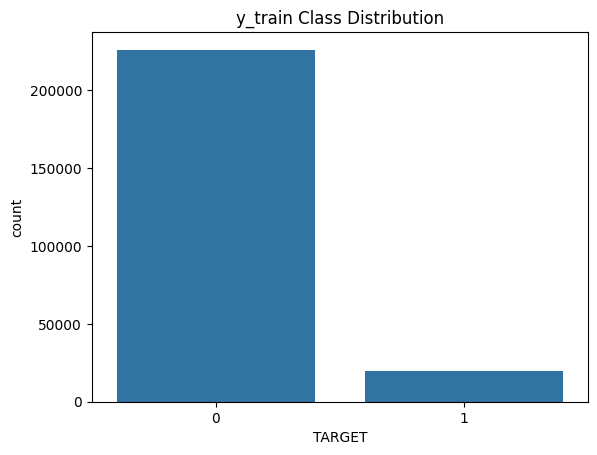

In [75]:
class_counts = Counter(y_train)
print("Class distribution:", class_counts)

total = len(y_train)
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} ({count/total*100:.2f}%)")

sns.countplot(x=y_train)
plt.title("y_train Class Distribution")
plt.show()

Distribution after SMOTE: Counter({0: 226148, 1: 226148})


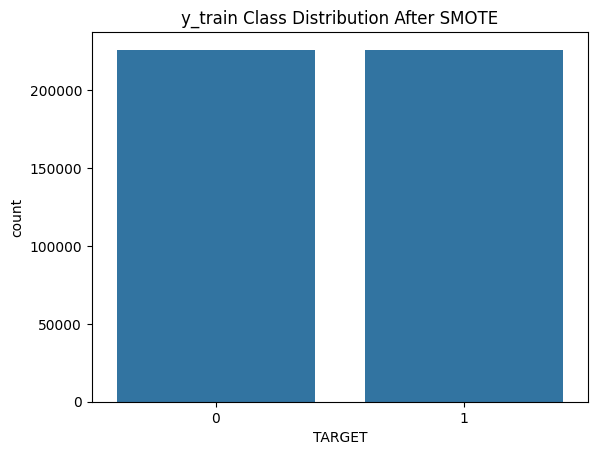

In [76]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_enc, y_train)

print("Distribution after SMOTE:", Counter(y_res))
sns.countplot(x=y_res)
plt.title("y_train Class Distribution After SMOTE")
plt.show()

# **9. Save Dataset**

In [ ]:
X_res.columns = X_res.columns.str.replace(r'[^0-9a-zA-Z_]', '_', regex=True)
X_val_enc.columns = X_val_enc.columns.str.replace(r'[^0-9a-zA-Z_]', '_', regex=True)
X_test_enc.columns = X_test_enc.columns.str.replace(r'[^0-9a-zA-Z_]', '_', regex=True)

df_res = pd.concat([X_res, y_res.reset_index(drop=True).rename("target")], axis=1)
df_val = pd.concat([X_val_enc.reset_index(drop=True), y_val.reset_index(drop=True).rename("target")], axis=1)
df_test = X_test_enc.copy()

df_res.to_csv("train_preprocessed.csv", index=False)
df_val.to_csv("val_preprocessed.csv", index=False)
df_test.to_csv("test_preprocessed.csv", index=False)

df_res_cat = pd.concat([X_train_scaled.reset_index(drop=True), y_train.reset_index(drop=True).rename("target")], axis=1)
df_val_cat = pd.concat([X_val_scaled.reset_index(drop=True), y_val.reset_index(drop=True).rename("target")], axis=1)
df_test_cat = X_test_scaled.copy()

df_res_cat.columns = df_res_cat.columns.str.replace(r'[^0-9a-zA-Z_]', '_', regex=True)
df_val_cat.columns = df_val_cat.columns.str.replace(r'[^0-9a-zA-Z_]', '_', regex=True)
df_test_cat.columns = df_test_cat.columns.str.replace(r'[^0-9a-zA-Z_]', '_', regex=True)

df_res_cat.to_csv("train_catboost.csv", index=False)
df_val_cat.to_csv("val_catboost.csv", index=False)
df_test_cat.to_csv("test_catboost.csv", index=False)

# **10. Feature Selection**

### **Logistic Regression**

LOGISTIC REGRESSION
Selected features: 108 out of 112 features
Features: ['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN']...
=== Logistic Regression Evaluation ===
Accuracy   : 0.719
Precision  : 0.155
Recall     : 0.558
F1-Score   : 0.243
ROC-AUC    : 0.706

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.73      0.83     56538
           1       0.16      0.56      0.24      4965

    accuracy                           0.72     61503
   macro avg       0.55      0.65      0.54     61503
weighted avg       0.89      0.72      0.78     61503


Confusion Matrix:
 [[41471 15067]
 [ 2197  2768]]


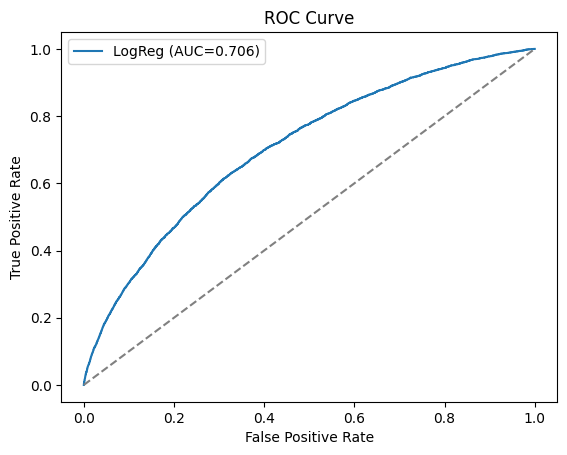

,Feature,Coefficient,Abs_Coefficient
69,HAS_BUILDING_INFO,-1.06,1.06
2,FLAG_OWN_CAR,-0.93,0.93
3,FLAG_OWN_REALTY,-0.79,0.79
30,EXT_SOURCE_3,-0.75,0.75
29,EXT_SOURCE_2,-0.67,0.67
92,NAME_EDUCATION_TYPE_Secondary___secondary_special,0.57,0.57
88,NAME_INCOME_TYPE_Working,0.50,0.50
106,WEEKDAY_APPR_PROCESS_START_TUESDAY,0.50,0.50
70,EXT_SOURCE_1_IS_MISSING,-0.48,0.48
107,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,0.48,0.48


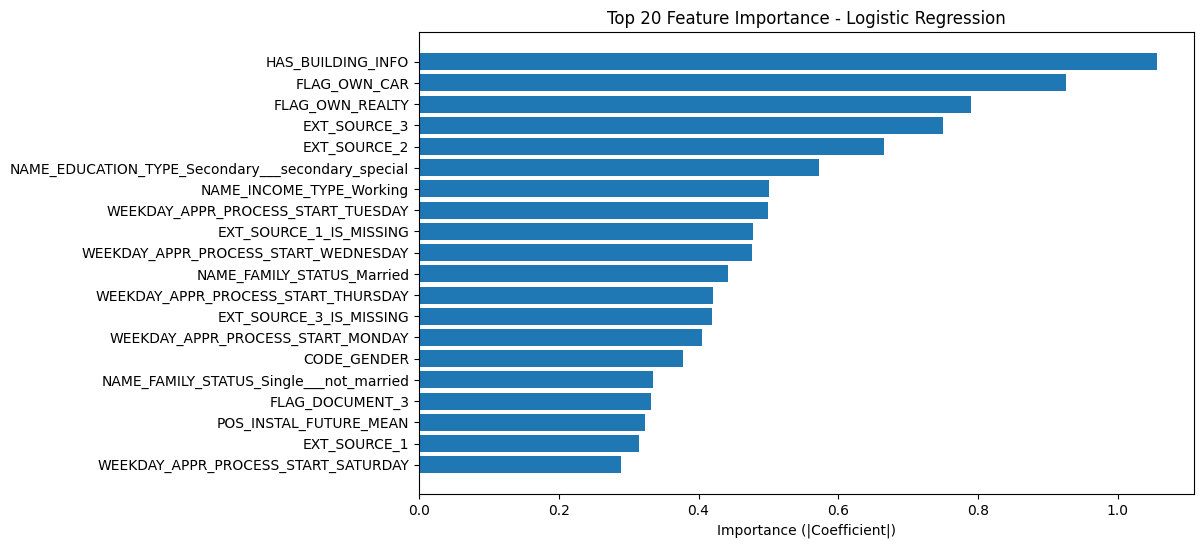

In [78]:
print("LOGISTIC REGRESSION")

# L1 regularization for feature selection
logreg_l1 = LogisticRegression(solver='saga', penalty="l1", C=1.0, max_iter=200, random_state=42, n_jobs=-1 )
logreg_l1.fit(X_res, y_res)

# Select features with non-zero coefficients
selected_features_logreg = X_res.columns[logreg_l1.coef_[0] != 0].tolist()
print(f"Selected features: {len(selected_features_logreg)} out of {X_res.shape[1]} features")
print(f"Features: {selected_features_logreg[:5]}...")

# Create new dataset with selected features
X_train_logreg = X_res[selected_features_logreg]
X_val_logreg = X_val_enc[selected_features_logreg]

# Retrain logistic regression without penalty
logreg_final = LogisticRegression(random_state=42)
logreg_final.fit(X_train_logreg, y_res)

# Test performance
y_pred_logreg = logreg_final.predict(X_val_logreg)
y_pred_proba_logreg = logreg_final.predict_proba(X_val_logreg)[:, 1]

acc_logreg = accuracy_score(y_val, y_pred_logreg)
prec_logreg = precision_score(y_val, y_pred_logreg)
rec_logreg = recall_score(y_val, y_pred_logreg)
f1_logreg = f1_score(y_val, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_val, y_pred_proba_logreg)

print("=== Logistic Regression Evaluation ===")
print(f"Accuracy   : {acc_logreg:.3f}")
print(f"Precision  : {prec_logreg:.3f}")
print(f"Recall     : {rec_logreg:.3f}")
print(f"F1-Score   : {f1_logreg:.3f}")
print(f"ROC-AUC    : {roc_auc_logreg:.3f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_logreg))

# Confusion matrix
cm_logreg = confusion_matrix(y_val, y_pred_logreg)
print("\nConfusion Matrix:\n", cm_logreg)

# ROC Curve
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_val, y_pred_proba_logreg)
plt.plot(fpr_logreg, tpr_logreg, label=f'LogReg (AUC={roc_auc_logreg:.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Feature importance
coef = logreg_final.coef_[0]
feature_importance = pd.DataFrame({
    "Feature": selected_features_logreg,
    "Coefficient": coef,
    "Abs_Coefficient": np.abs(coef)
})

feature_importance = feature_importance.sort_values(by="Abs_Coefficient", ascending=False)
display(feature_importance.head(50))

plt.figure(figsize=(10,6))
plt.barh(feature_importance["Feature"][:20], feature_importance["Abs_Coefficient"][:20])
plt.gca().invert_yaxis()
plt.xlabel("Importance (|Coefficient|)")
plt.title("Top 20 Feature Importance - Logistic Regression")
plt.show()

### **Random Forest**

RANDOM FOREST
Selected features: 50 out of 112 features
Features: ['SK_ID_CURR', 'FLAG_OWN_CAR', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']...
=== Random Forest Evaluation ===
Accuracy   : 0.918
Precision  : 0.341
Recall     : 0.021
F1-Score   : 0.039
ROC-AUC    : 0.728

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.34      0.02      0.04      4965

    accuracy                           0.92     61503
   macro avg       0.63      0.51      0.50     61503
weighted avg       0.87      0.92      0.88     61503


Confusion Matrix:
 [[56339   199]
 [ 4862   103]]


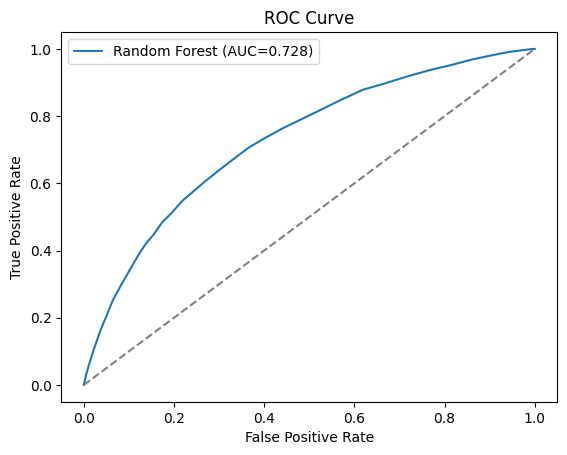

,Feature,Importance
11,FLAG_PHONE,0.07
20,EXT_SOURCE_3,0.05
33,PREV_REFUSED_COUNT,0.05
18,EXT_SOURCE_1,0.05
23,FLAG_DOCUMENT_3,0.05
19,EXT_SOURCE_2,0.04
44,NAME_EDUCATION_TYPE_Secondary___secondary_special,0.03
21,OBS_30_CNT_SOCIAL_CIRCLE,0.03
37,HAS_BUILDING_INFO,0.03
32,PREV_APPROVED_COUNT,0.03


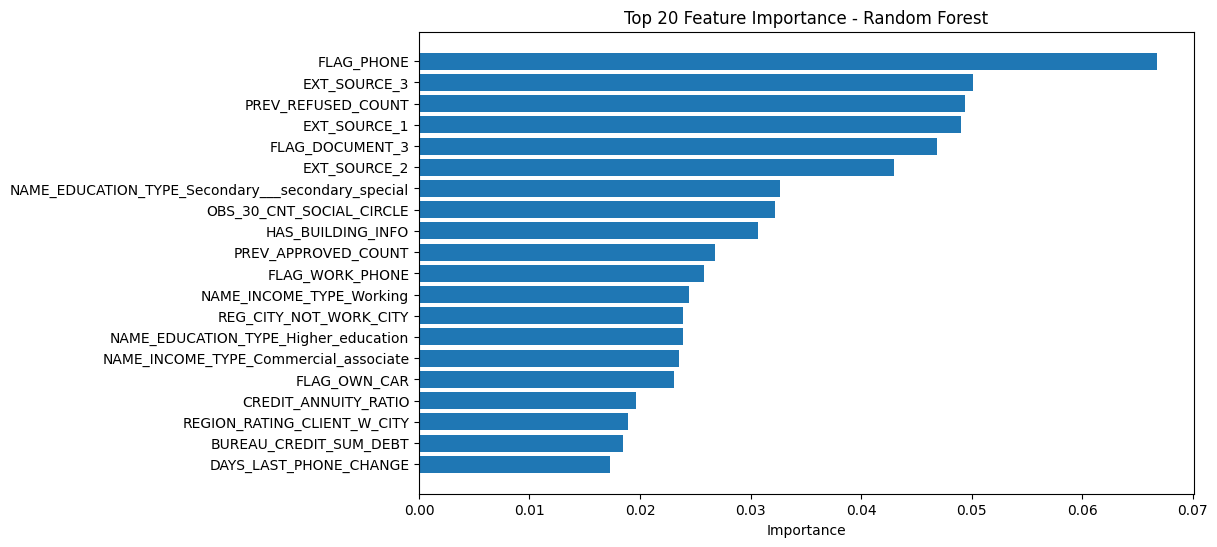

In [79]:
print("RANDOM FOREST")

# Smaller sampling for feature selection
X_sub, _, y_sub, _ = train_test_split(X_res, y_res, train_size=8000, stratify=y_res, random_state=42)

rf_temp = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
rf_temp.fit(X_sub, y_sub)

# Permutation importance (lighter: n_repeats=3, data subset)
perm_importance = permutation_importance(rf_temp, X_sub, y_sub, n_repeats=3, random_state=42, n_jobs=-1)
importance_threshold = np.percentile(perm_importance.importances_mean, 50)
important_features = X_res.columns[perm_importance.importances_mean > importance_threshold]

# RFECV with RandomForest (smaller estimator + sample)
X_train_filtered = X_res[important_features].sample(5000, random_state=42)
y_train_filtered = y_res.sample(5000, random_state=42)

rf_selector = RFECV(
    RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1),
    cv=3,
    scoring='accuracy',
    min_features_to_select=5,
    n_jobs=-1
)
rf_selector.fit(X_train_filtered, y_train_filtered)

selected_features_rf = X_train_filtered.columns[rf_selector.support_].tolist()
print(f"Selected features: {len(selected_features_rf)} out of {X_res.shape[1]} features")
print(f"Features: {selected_features_rf[:5]}...")  # show first 5

# Retrain final model with all data & selected features
rf_final = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_final.fit(X_res[selected_features_rf], y_res)

# Test performance
y_pred_rf = rf_final.predict(X_val_enc[selected_features_rf])
y_pred_proba_rf = rf_final.predict_proba(X_val_enc[selected_features_rf])[:, 1]

acc_rf = accuracy_score(y_val, y_pred_rf)
prec_rf = precision_score(y_val, y_pred_rf)
rec_rf = recall_score(y_val, y_pred_rf)
f1_rf = f1_score(y_val, y_pred_rf)
roc_auc_rf = roc_auc_score(y_val, y_pred_proba_rf)

print("=== Random Forest Evaluation ===")
print(f"Accuracy   : {acc_rf:.3f}")
print(f"Precision  : {prec_rf:.3f}")
print(f"Recall     : {rec_rf:.3f}")
print(f"F1-Score   : {f1_rf:.3f}")
print(f"ROC-AUC    : {roc_auc_rf:.3f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_val, y_pred_rf)
print("\nConfusion Matrix:\n", cm_rf)

# ROC Curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_rf:.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Feature importance
feature_importance_rf = pd.DataFrame({
    "Feature": selected_features_rf,
    "Importance": rf_final.feature_importances_
}).sort_values(by="Importance", ascending=False)

display(feature_importance_rf.head(50))

plt.figure(figsize=(10,6))
plt.barh(feature_importance_rf["Feature"][:20], feature_importance_rf["Importance"][:20])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 20 Feature Importance - Random Forest")
plt.show()

### **XGBoost**

XGBOOST
Selected features: 56 out of 112 features
Features: ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE']...
=== XGBoost Evaluation ===
Accuracy   : 0.919
Precision  : 0.454
Recall     : 0.035
F1-Score   : 0.065
ROC-AUC    : 0.754

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.45      0.03      0.06      4965

    accuracy                           0.92     61503
   macro avg       0.69      0.52      0.51     61503
weighted avg       0.88      0.92      0.89     61503


Confusion Matrix:
 [[56330   208]
 [ 4792   173]]


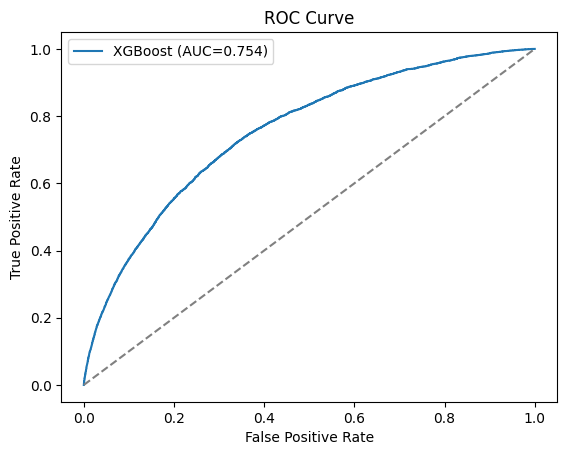

,Feature,Importance
39,NAME_EDUCATION_TYPE_Higher_education,0.07
6,FLAG_PHONE,0.06
42,NAME_EDUCATION_TYPE_Secondary___secondary_special,0.05
28,PREV_REFUSED_COUNT,0.04
19,FLAG_DOCUMENT_3,0.04
35,NAME_TYPE_SUITE_Unaccompanied,0.04
30,HAS_BUILDING_INFO,0.04
14,LIVE_CITY_NOT_WORK_CITY,0.04
32,NAME_TYPE_SUITE_Family,0.04
36,NAME_INCOME_TYPE_Commercial_associate,0.04


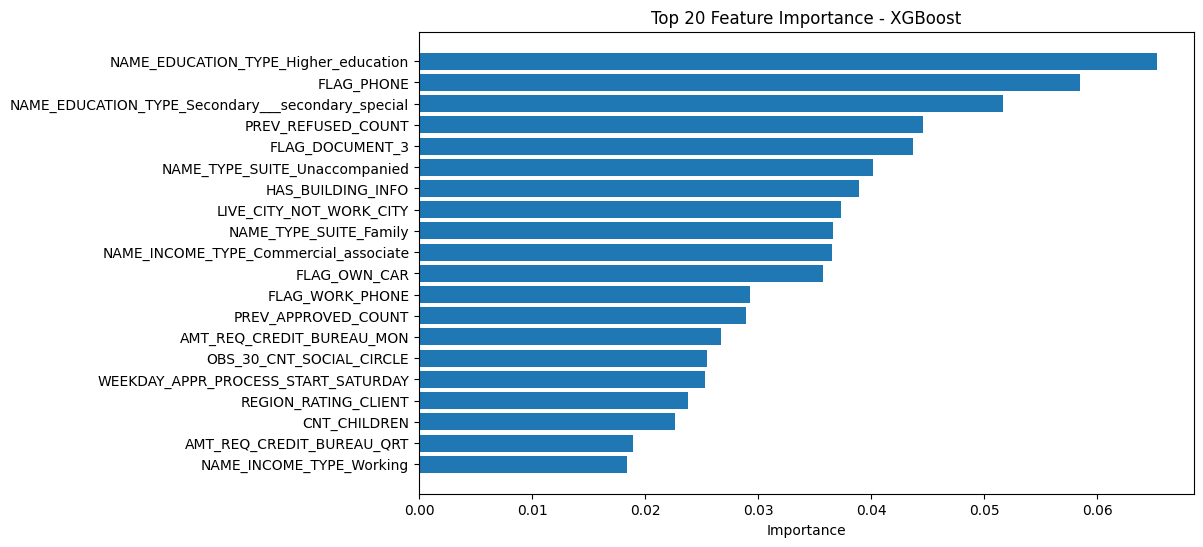

In [80]:
print("XGBOOST")

# Fit XGBoost temporarily for feature selection
xgb_temp = XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1)
xgb_temp.fit(X_res, y_res)

# Feature selection using median importance
selector = SelectFromModel(xgb_temp, threshold="median", prefit=True)
selected_features_xgb = X_res.columns[selector.get_support()].tolist()

print(f"Selected features: {len(selected_features_xgb)} out of {X_res.shape[1]} features")
print(f"Features: {selected_features_xgb[:5]}...")  # show first 5

# Retrain final model with selected features
xgb_final = XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1)
xgb_final.fit(X_res[selected_features_xgb], y_res)

# Evaluation on validation set
y_pred_xgb = xgb_final.predict(X_val_enc[selected_features_xgb])
y_pred_proba_xgb = xgb_final.predict_proba(X_val_enc[selected_features_xgb])[:, 1]

acc_xgb = accuracy_score(y_val, y_pred_xgb)
prec_xgb = precision_score(y_val, y_pred_xgb)
rec_xgb = recall_score(y_val, y_pred_xgb)
f1_xgb = f1_score(y_val, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_val, y_pred_proba_xgb)

print("=== XGBoost Evaluation ===")
print(f"Accuracy   : {acc_xgb:.3f}")
print(f"Precision  : {prec_xgb:.3f}")
print(f"Recall     : {rec_xgb:.3f}")
print(f"F1-Score   : {f1_xgb:.3f}")
print(f"ROC-AUC    : {roc_auc_xgb:.3f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_xgb))

# Confusion matrix
cm_xgb = confusion_matrix(y_val, y_pred_xgb)
print("\nConfusion Matrix:\n", cm_xgb)

# ROC Curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_val, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_xgb:.3f})')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    "Feature": selected_features_xgb,
    "Importance": xgb_final.feature_importances_
})

feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
display(feature_importance.head(50))

plt.figure(figsize=(10,6))
plt.barh(feature_importance["Feature"][:20], feature_importance["Importance"][:20])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 20 Feature Importance - XGBoost")
plt.show()

### **Naive Bayes**

NAIVE BAYES
Selected features: 15 out of 112 features
Features: ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_1']...
=== Naive Bayes Evaluation ===
Accuracy   : 0.719
Precision  : 0.139
Recall     : 0.479
F1-Score   : 0.216
ROC-AUC    : 0.654

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.74      0.83     56538
           1       0.14      0.48      0.22      4965

    accuracy                           0.72     61503
   macro avg       0.54      0.61      0.52     61503
weighted avg       0.88      0.72      0.78     61503


Confusion Matrix:
 [[41869 14669]
 [ 2589  2376]]


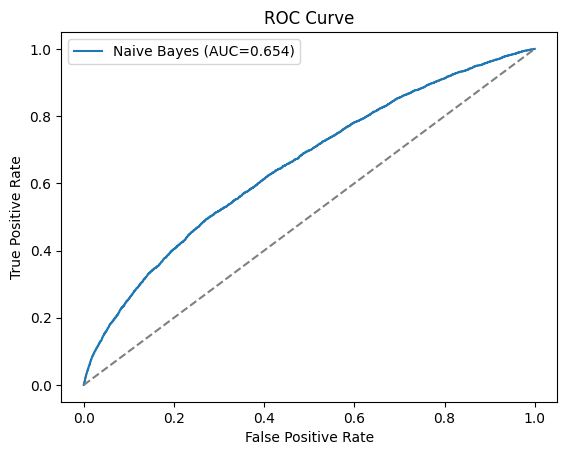

In [81]:
print("NAIVE BAYES")

# Univariate feature selection
nb_selector = SelectKBest(score_func=f_classif, k=15)  # select top 15 features
X_train_nb = nb_selector.fit_transform(X_res, y_res)
X_val_nb = nb_selector.transform(X_val_enc)

selected_features_nb = X_res.columns[nb_selector.get_support()].tolist()
print(f"Selected features: {len(selected_features_nb)} out of {X_res.shape[1]} features")
print(f"Features: {selected_features_nb[:5]}...")  # show first 5

# Retrain and evaluate
nb_final = GaussianNB()
nb_final.fit(X_train_nb, y_res)

y_pred_nb = nb_final.predict(X_val_nb)
y_pred_proba_nb = nb_final.predict_proba(X_val_nb)[:, 1]

acc_nb = accuracy_score(y_val, y_pred_nb)
prec_nb = precision_score(y_val, y_pred_nb)
rec_nb = recall_score(y_val, y_pred_nb)
f1_nb = f1_score(y_val, y_pred_nb)
roc_auc_nb = roc_auc_score(y_val, y_pred_proba_nb)

print("=== Naive Bayes Evaluation ===")
print(f"Accuracy   : {acc_nb:.3f}")
print(f"Precision  : {prec_nb:.3f}")
print(f"Recall     : {rec_nb:.3f}")
print(f"F1-Score   : {f1_nb:.3f}")
print(f"ROC-AUC    : {roc_auc_nb:.3f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_nb))

# Confusion matrix
cm_nb = confusion_matrix(y_val, y_pred_nb)
print("\nConfusion Matrix:\n", cm_nb)

# ROC Curve
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_val, y_pred_proba_nb)
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC={roc_auc_nb:.3f})')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### **LightGBM**

LIGHTGBM
[LightGBM] [Info] Number of positive: 226148, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14558
[LightGBM] [Info] Number of data points in the train set: 452296, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Selected features: 56 out of 112 features
Features: ['CODE_GENDER', 'FLAG_OWN_CAR', 'CNT_CHILDREN', 'AMT_CREDIT', 'AMT_ANNUITY']...
[LightGBM] [Info] Number of positive: 226148, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9221
[LightGBM] [Info] Number of data points in the train set: 452296, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50

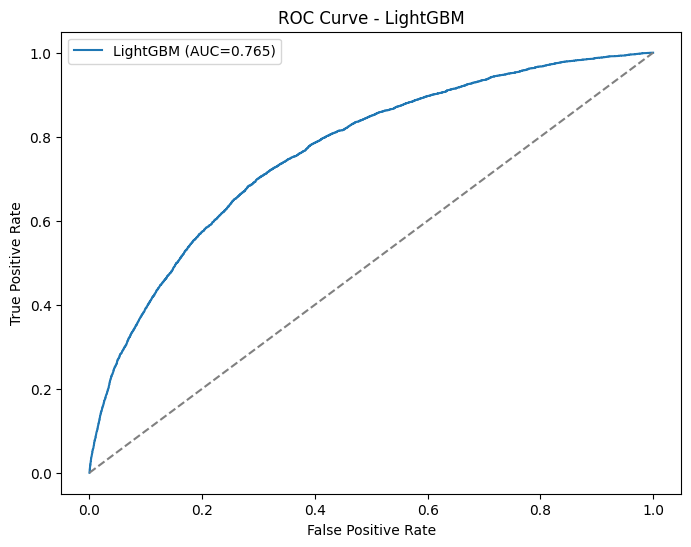

,Feature,Importance
32,PREV_APPROVED_COUNT,254
21,OBS_30_CNT_SOCIAL_CIRCLE,175
15,HOUR_APPR_PROCESS_START,173
33,PREV_REFUSED_COUNT,131
27,CREDIT_ANNUITY_RATIO,123
19,EXT_SOURCE_2,112
20,EXT_SOURCE_3,110
26,AMT_REQ_CREDIT_BUREAU_YEAR,101
18,EXT_SOURCE_1,81
11,FLAG_PHONE,80


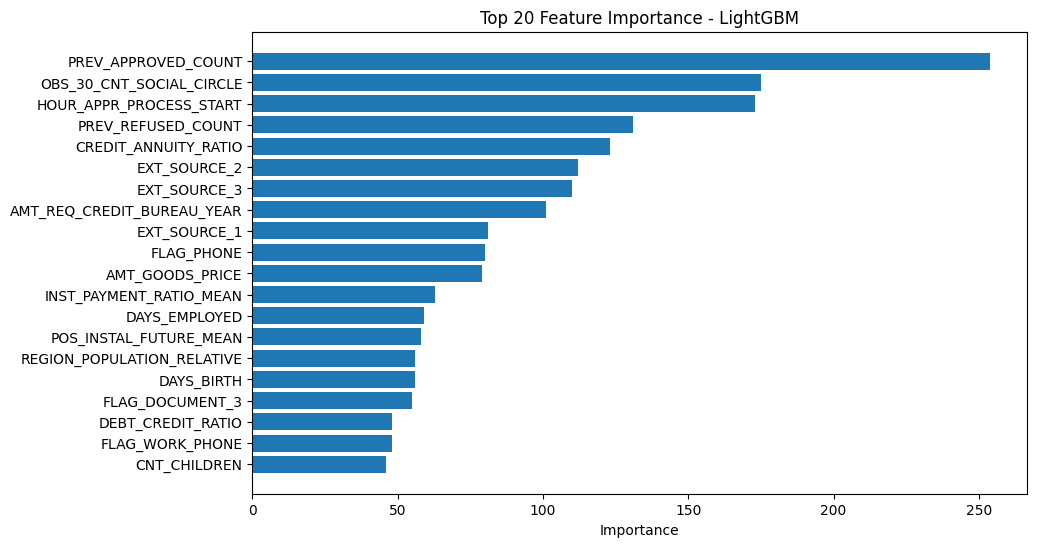

In [82]:
print("LIGHTGBM")

# Train initial LightGBM model
lgb_temp = LGBMClassifier(random_state=42, n_jobs=-1)
lgb_temp.fit(X_res, y_res)

# Feature selection based on importance
selector = SelectFromModel(lgb_temp, threshold="median", prefit=True)
selected_features_lgb = X_res.columns[selector.get_support()].tolist()

print(f"Selected features: {len(selected_features_lgb)} out of {X_res.shape[1]} features")
print(f"Features: {selected_features_lgb[:5]}...")  # show first 5

# Retrain model with selected features
X_train_lgb = X_res[selected_features_lgb]
X_val_lgb = X_val_enc[selected_features_lgb]

lgb_final = LGBMClassifier(random_state=42, n_jobs=-1)
lgb_final.fit(X_train_lgb, y_res)

# Predict and evaluate
y_pred_lgb = lgb_final.predict(X_val_lgb)
y_proba_lgb = lgb_final.predict_proba(X_val_lgb)[:, 1]

acc_lgb = accuracy_score(y_val, y_pred_lgb)
prec_lgb = precision_score(y_val, y_pred_lgb)
rec_lgb = recall_score(y_val, y_pred_lgb)
f1_lgb = f1_score(y_val, y_pred_lgb)
roc_auc_lgb = roc_auc_score(y_val, y_proba_lgb)

print("=== LightGBM Evaluation ===")
print(f"Accuracy   : {acc_lgb:.3f}")
print(f"Precision  : {prec_lgb:.3f}")
print(f"Recall     : {rec_lgb:.3f}")
print(f"F1-Score   : {f1_lgb:.3f}")
print(f"ROC-AUC    : {roc_auc_lgb:.3f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_lgb))

# Confusion matrix
cm_lgb = confusion_matrix(y_val, y_pred_lgb)
print("\nConfusion Matrix:\n", cm_lgb)

# ROC Curve
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_val, y_proba_lgb)
plt.figure(figsize=(8,6))
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC={roc_auc_lgb:.3f})')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM")
plt.legend()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    "Feature": selected_features_lgb,
    "Importance": lgb_final.feature_importances_
})

feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
display(feature_importance.head(50))

plt.figure(figsize=(10,6))
plt.barh(feature_importance["Feature"][:20], feature_importance["Importance"][:20])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 20 Feature Importance - LightGBM")
plt.show()

### **CatBoost**

CATBOOST
Selected features: 43 out of 85 features
Features: ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_CREDIT']...
=== CatBoost Evaluation ===
Accuracy   : 0.920
Precision  : 0.544
Recall     : 0.048
F1-Score   : 0.089
ROC-AUC    : 0.781

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.54      0.05      0.09      4965

    accuracy                           0.92     61503
   macro avg       0.73      0.52      0.52     61503
weighted avg       0.89      0.92      0.89     61503


Confusion Matrix:
 [[56337   201]
 [ 4725   240]]


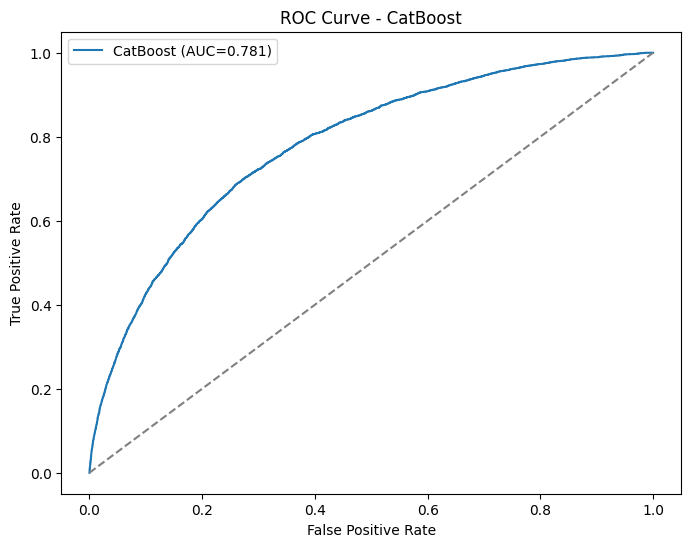

,Feature,Importance
25,EXT_SOURCE_3,9.52
24,EXT_SOURCE_2,8.96
23,EXT_SOURCE_1,7.90
31,CREDIT_ANNUITY_RATIO,7.58
13,DAYS_BIRTH,4.56
40,POS_INSTAL_FUTURE_MEAN,3.54
14,DAYS_EMPLOYED,3.44
32,BUREAU_CREDIT_SUM,3.23
6,AMT_GOODS_PRICE,3.22
5,AMT_ANNUITY,2.93


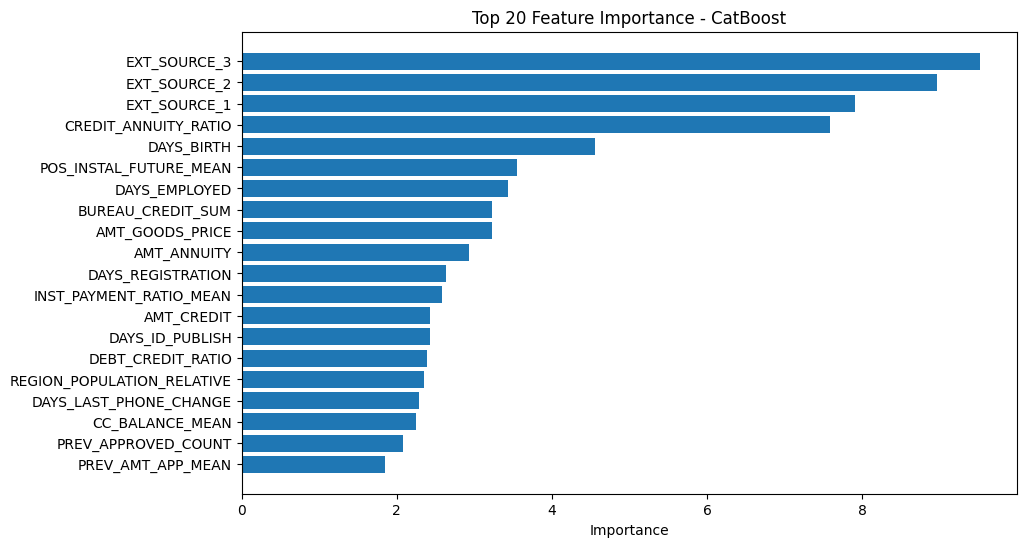

In [83]:
print("CATBOOST")

# Sanitize column names
X_train_scaled.columns = X_train_scaled.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_val_scaled.columns = X_val_scaled.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# Train initial CatBoost model
cat_temp = CatBoostClassifier(random_state=42, verbose=0, )
cat_temp.fit(X_train_scaled, y_train, cat_features=cat_cols)

# Feature selection using model importance
selector = SelectFromModel(cat_temp, threshold="median", prefit=True)
selected_features_cat = X_train_scaled.columns[selector.get_support()].tolist()

print(f"Selected features: {len(selected_features_cat)} out of {X_train_scaled.shape[1]} features")
print(f"Features: {selected_features_cat[:5]}...")  # show first 5

# Retrain model with selected features
X_train_cat = X_train_scaled[selected_features_cat]
X_val_cat = X_val_scaled[selected_features_cat]
cat_features_final = [i for i, col in enumerate(X_train_cat.columns) if col in cat_cols]

cat_final = CatBoostClassifier(random_state=42, verbose=0)
cat_final.fit(X_train_cat, y_train, cat_features=cat_features_final)

# Predict and evaluate
y_pred_cat = cat_final.predict(X_val_cat)
y_proba_cat = cat_final.predict_proba(X_val_cat)[:, 1]

acc_cat = accuracy_score(y_val, y_pred_cat)
prec_cat = precision_score(y_val, y_pred_cat)
rec_cat = recall_score(y_val, y_pred_cat)
f1_cat = f1_score(y_val, y_pred_cat)
roc_auc_cat = roc_auc_score(y_val, y_proba_cat)

print("=== CatBoost Evaluation ===")
print(f"Accuracy   : {acc_cat:.3f}")
print(f"Precision  : {prec_cat:.3f}")
print(f"Recall     : {rec_cat:.3f}")
print(f"F1-Score   : {f1_cat:.3f}")
print(f"ROC-AUC    : {roc_auc_cat:.3f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_cat))

# Confusion matrix
cm_cat = confusion_matrix(y_val, y_pred_cat)
print("\nConfusion Matrix:\n", cm_cat)

# ROC Curve
fpr_cat, tpr_cat, thresholds_cat = roc_curve(y_val, y_proba_cat)
plt.figure(figsize=(8,6))
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC={roc_auc_cat:.3f})')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CatBoost")
plt.legend()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    "Feature": selected_features_cat,
    "Importance": cat_final.get_feature_importance()
})

feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
display(feature_importance.head(50))

plt.figure(figsize=(10,6))
plt.barh(feature_importance["Feature"][:20], feature_importance["Importance"][:20])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 20 Feature Importance - CatBoost")
plt.show()

### **Save Selected Features** 

In [84]:
features_dict = {
    "LogisticRegression": selected_features_logreg,
    "RandomForest": selected_features_rf,
    "XGBoost": selected_features_xgb,
    "NaiveBayes": selected_features_nb,
    "LightGBM": selected_features_lgb,
    "CatBoost": selected_features_cat
}

features_df = pd.DataFrame([
    {"Model": model, "Selected_Features": ",".join(features)}
    for model, features in features_dict.items()
])

features_df.to_csv("selected_features_all_models.csv", index=False)
display(features_df)

,Model,Selected_Features
0,LogisticRegression,"SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_R..."
1,RandomForest,"SK_ID_CURR,FLAG_OWN_CAR,AMT_CREDIT,AMT_ANNUITY..."
2,XGBoost,"FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_..."
3,NaiveBayes,"FLAG_OWN_CAR,FLAG_OWN_REALTY,DAYS_BIRTH,DAYS_E..."
4,LightGBM,"CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_CRED..."
5,CatBoost,"SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG..."
